In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision import transforms
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 

# Data

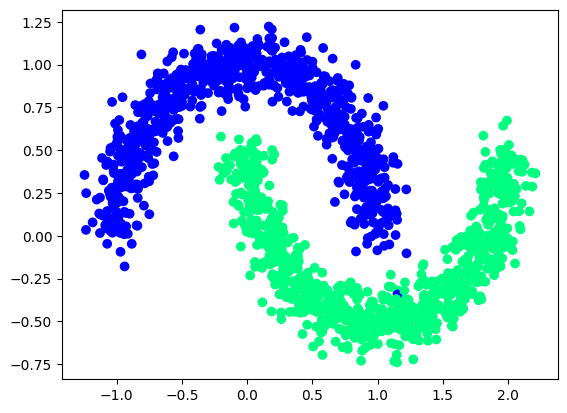

In [16]:
#data 불러오기
x, y = make_moons(n_samples=2000, noise=0.1)

#train, test split 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=13)

# plot 
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, cmap=plt.cm.winter)

# Custom Dataset

In [17]:
# Dataset 상속
class train_labeled_set(Dataset): 
  def __init__(self,x,y):
    self.x_train_labeled = x[:40]
    self.y_train_labeled = y[:40]
    
  def __len__(self): 
    return len(self.x_train_labeled)

  def __getitem__(self, idx): 
    temp1 = torch.Tensor(self.x_train_labeled[idx:idx+1]).view(-1, )
    temp2 = torch.Tensor(self.y_train_labeled[idx:idx+1]).view(-1, )
    
    return temp1, temp2

class train_unlabeled_set(Dataset):
  def __init__(self,x,y):
    self.x_train_unlabeled = x[40:]
    
  def __len__(self): 
    return len(self.x_train_unlabeled)

  def __getitem__(self, idx): 
    temp1 = torch.Tensor(self.x_train_unlabeled[idx:idx+1]).view(-1, )
  
    return temp1


class test_labeled_set(Dataset): 
  def __init__(self,x,y):
    self.x_test_labeled = x
    self.y_test_labeled = y
    
  def __len__(self): 
    return len(self.x_test_labeled)

  def __getitem__(self, idx): 
    temp1 = torch.Tensor(self.x_test_labeled[idx:idx+1]).view(-1, )
    temp2 = torch.Tensor(self.y_test_labeled[idx:idx+1]).view(-1, )
    
    return temp1, temp2


In [18]:
# Noise Function
def noise_fn1(x): 
    mu =0.0
    sigma = 0.2

    if x.shape[0]==32: 
        noise = torch.normal(mean = mu ,std = sigma, size =(32,2))
    else : 
        noise = torch.normal(mean = mu ,std = sigma, size =(x.shape[0],2))
        
   
    return x+noise


# Hyper-parameter

In [19]:
input_size = 2
hidden_size = 100
output_size = 1
BATCH_SIZE = 32
EPOCHS = 800
DEVICE = 'mps'
lr= 0.001
K=2
T=0.5

# DataLoader

In [20]:
train_labeled_set=train_labeled_set(x_train,y_train)
train_labeled_Dataloader = DataLoader(train_labeled_set, batch_size=1, shuffle=True,)
train_unlabeled_set=train_unlabeled_set(x_train,y_train)
train_unlabeled_Dataloader = DataLoader(train_unlabeled_set,batch_size=BATCH_SIZE, shuffle=True,)
test_labeled_set = test_labeled_set(x_test,y_test)
test_labeled_Dataloader = DataLoader(test_labeled_set,batch_size=BATCH_SIZE,shuffle=True,)

In [21]:
x, y  = next(iter(train_labeled_Dataloader)) #train_loader(라벨있는 것)
print(x.shape)
print(y.shape)
print()

x = next(iter(train_unlabeled_Dataloader)) #train_loader(라벨없는 것)
print(x.shape)
print()

x,y = next(iter(test_labeled_Dataloader))  #test
print(x.shape)
print(y.shape)

torch.Size([1, 2])
torch.Size([1, 1])

torch.Size([32, 2])

torch.Size([32, 2])
torch.Size([32, 1])


# Model

In [22]:
class NET(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.NN =nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,output_size),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.NN(x)

In [23]:
model = NET(input_size,hidden_size,output_size)
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion1 = nn.BCELoss()
criterion2 = nn.MSELoss()

# Mix(Make fake label)

In [24]:
def mix(input_x, input_u, noise_fn1, K=2):
    X = noise_fn1(input_x)
    U = [noise_fn1(input_u) for _ in range(K)]
    Aug_1 = model(U[0]) #augmentation 1 
    Aug_2 = model(U[1]) #augmentation 2
    Aug_avg = (Aug_1+Aug_2)/2 #augmentation average
    Ux = torch.Tensor(np.concatenate(U, axis=0))
    Uy = torch.Tensor(np.concatenate([Aug_avg.detach().numpy() for _ in range(K)], axis=0))
    
    return X,U,Ux,Uy

# Train

In [25]:
def train(model, train_labeled_Dataloader, train_unlabeled_Dataloader, epoch, optimizer,criterion1,criterion2):
    model.train()
    train_loss = 0 
    EPOCHS = 800
    per = EPOCHS/5

    #ramp_up
    if epoch < per:
        ramp = 0.1
    elif epoch < per*2: 
        ramp = 0.2
    elif epoch < per*3: 
        ramp = 0.4
    elif epoch < per*4:
        ramp = 0.8
    elif epoch < per*5: 
        ramp = 1
    else:
        ramp = 1.2

    for _ in range(len(train_unlabeled_Dataloader)):
        input_x, target_x = next(iter(train_labeled_Dataloader))
        input_u = next(iter(train_unlabeled_Dataloader))
        X, U, Ux, Uy = mix(input_x, input_u, noise_fn1)
        
        optimizer.zero_grad()
        output1 = model(X)
        output2 = model(Ux)
        loss_1 = criterion1(output1,target_x) 
        loss_2 = ramp * criterion2(output2, Uy)
        total_loss = loss_1+loss_2
        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()
    train_loss /= len(train_unlabeled_Dataloader)
    #print(loss_1, loss_2)
    
    return train_loss

# Evaluate

In [26]:
from sklearn.metrics import accuracy_score

def evaluate(model,test_labeled_Dataloader,criterion1):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_labeled_Dataloader:
            data = data
            target = target
            output = model(data)
            test_loss += criterion1(output, target).item()
            pred = output.data.cpu().numpy()>0.5
            #acc = accuracy_score(target, pred)

    test_loss /= len(test_labeled_Dataloader)

    plt.scatter(data[:,0], data[:,1], c=pred, cmap=plt.cm.winter)
    return test_loss

[EPOCH: 0], 	Train Loss: 0.6954,	Val Loss: 0.6856
[EPOCH: 1], 	Train Loss: 0.6851,	Val Loss: 0.6781
[EPOCH: 2], 	Train Loss: 0.6754,	Val Loss: 0.6696
[EPOCH: 3], 	Train Loss: 0.6695,	Val Loss: 0.6621
[EPOCH: 4], 	Train Loss: 0.6598,	Val Loss: 0.6545
[EPOCH: 5], 	Train Loss: 0.6375,	Val Loss: 0.6433
[EPOCH: 6], 	Train Loss: 0.6413,	Val Loss: 0.6354
[EPOCH: 7], 	Train Loss: 0.6459,	Val Loss: 0.6311
[EPOCH: 8], 	Train Loss: 0.6314,	Val Loss: 0.6244
[EPOCH: 9], 	Train Loss: 0.6193,	Val Loss: 0.6191
[EPOCH: 10], 	Train Loss: 0.5987,	Val Loss: 0.6081
[EPOCH: 11], 	Train Loss: 0.5791,	Val Loss: 0.5974
[EPOCH: 12], 	Train Loss: 0.5762,	Val Loss: 0.5889
[EPOCH: 13], 	Train Loss: 0.5880,	Val Loss: 0.5806
[EPOCH: 14], 	Train Loss: 0.5814,	Val Loss: 0.5729
[EPOCH: 15], 	Train Loss: 0.5713,	Val Loss: 0.5651
[EPOCH: 16], 	Train Loss: 0.5581,	Val Loss: 0.5579
[EPOCH: 17], 	Train Loss: 0.5439,	Val Loss: 0.5495
[EPOCH: 18], 	Train Loss: 0.5115,	Val Loss: 0.5378
[EPOCH: 19], 	Train Loss: 0.5410,	Val Los

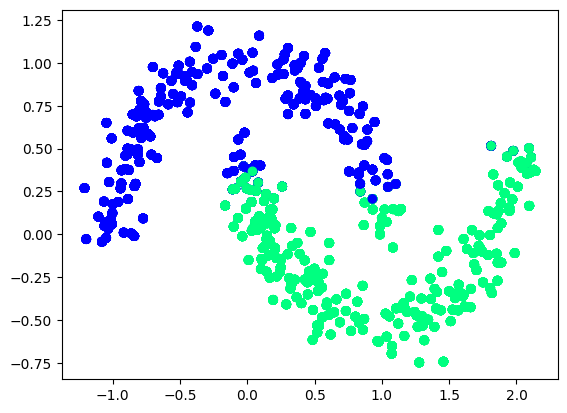

In [27]:
result_list = []
for epoch in range(0, EPOCHS + 1):
  train_loss=train(model, train_labeled_Dataloader,train_unlabeled_Dataloader,epoch,optimizer,criterion1,criterion2)
  val_loss = evaluate(model, test_labeled_Dataloader,criterion1)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f},\tVal Loss: {val_loss:.4f}")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    #'Val Accuracy': val_accuracy
    }
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)


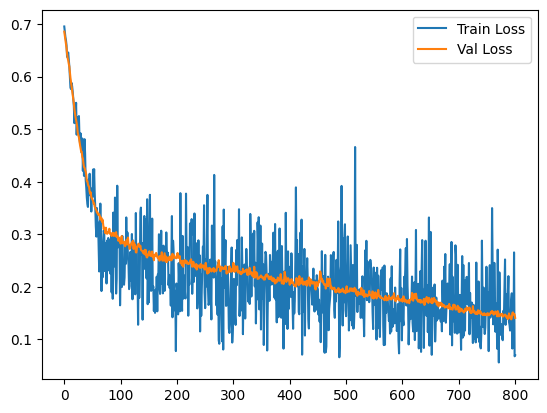

In [28]:
result_df['Train Loss'].plot()
result_df['Val Loss'].plot()
plt.legend()